In [1]:
%matplotlib inline
from __future__ import division
from collections import OrderedDict

import pandas as pd
import numpy as np

import empyrical as ep
import pyfolio as pf
import alphalens as al

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.precision', 3)
sns.set_context('talk')
sns.set_style('whitegrid')

In [2]:
stock_rets_specific = pd.read_csv('specific_stock_rets_testing.csv', index_col=0, parse_dates=True).dropna(how='all')
stock_rets_specific.index = stock_rets_specific.index.tz_localize('utc')
stock_rets_specific.columns = stock_rets_specific.columns.map(int)
stock_rets = pd.read_csv('stock_rets_testing.csv', index_col=0, parse_dates=True).dropna(how='all')
stock_rets.index = stock_rets.index.tz_localize('utc')
stock_rets.columns = stock_rets.columns.map(int)
implied_prices = ep.cum_returns(stock_rets, starting_value=1.)
risk_loadings = pd.read_hdf('risk_loadings_testing.hdf5')
risk_loadings.index = risk_loadings.index.set_levels(risk_loadings.index.levels[0].tz_localize('utc'), 0)
risk_returns = pd.read_hdf('risk_returns_testing.hdf5')
short_vol = pd.read_hdf('short_vol_sid.hdf5')

In [3]:
# Code for tearsheet
def calc_perf_attrib(portfolio_returns, portfolio_pos, factor_returns, factor_loadings):
    import empyrical as ep
    start = portfolio_returns.index[0]
    end = portfolio_returns.index[-1]
    factor_loadings.index = factor_loadings.index.set_names(['dt', 'ticker'])
    portfolio_pos.index = portfolio_pos.index.set_names(['dt'])
    
    portfolio_pos = portfolio_pos.drop('cash', axis=1)
    portfolio_pos.columns.name = 'ticker'
    portfolio_pos.columns = portfolio_pos.columns.astype('int')
    
    return ep.perf_attrib(
        portfolio_returns, 
        portfolio_pos.stack().dropna(),
        factor_returns.loc[start:end], 
        factor_loadings.loc[start:end])

def plot_exposures(risk_exposures, ax=None):
    rep = risk_exposures.stack().reset_index()
    rep.columns = ['dt', 'factor', 'exposure']
    sns.boxplot(x='exposure', y='factor', data=rep, orient='h', ax=ax, order=risk_exposures.columns[::-1])

def plot_overview_tear_sheet(factor, pricing, factor_returns, factor_loadings, periods=range(1, 15), view=None):
    factor_data_total = al.utils.get_clean_factor_and_forward_returns(
        factor, 
        pricing,
        quantiles=None,
        bins=(-np.inf, 0, np.inf),
        periods=periods,
        cumulative_returns=False,
    )

    portfolio_returns_total = al.performance.factor_returns(factor_data_total)
    portfolio_returns_total.columns = portfolio_returns_total.columns.map(lambda x: int(x[:-1]))
    for i in portfolio_returns_total.columns:
        portfolio_returns_total[i] = portfolio_returns_total[i].shift(i)

    portfolio_returns_specific = pd.DataFrame(columns=portfolio_returns_total.columns, index=portfolio_returns_total.index)
    
    # closure
    def calc_perf_attrib_c(i, portfolio_returns_total=portfolio_returns_total, 
                           factor_data_total=factor_data_total, factor_returns=factor_returns, 
                           factor_loadings=factor_loadings):
        return calc_perf_attrib(portfolio_returns_total[i], 
                              factor_data_total['factor'].unstack().assign(cash=0).shift(i), 
                              factor_returns, factor_loadings)
    
    if view is None:
        perf_attrib = map(calc_perf_attrib_c, portfolio_returns_total.columns)
    else:
        perf_attrib = view.map_sync(calc_perf_attrib_c, portfolio_returns_total.columns)
        
    for i, pa in enumerate(perf_attrib):
        if i == 0:
            risk_exposures_portfolio = pa[0]
            perf_attribution = pa[1]
        portfolio_returns_specific[i + 1] = pa[1]['specific_returns']
    
    fig = plt.figure(figsize=(16, 16))
    gs = plt.GridSpec(4, 4)
    ax1 = plt.subplot(gs[0:2, 0:2])

    delay_sharpes_total = portfolio_returns_total.apply(ep.sharpe_ratio)
    delay_sharpes_specific = portfolio_returns_specific.apply(ep.sharpe_ratio)
    
    pd.DataFrame({'specific': delay_sharpes_specific, 
                  'total': delay_sharpes_total}).plot.bar(ax=ax1)
    ax1.set(xlabel='delay', ylabel='IR')

    ax2a = plt.subplot(gs[0, 2:4])
    delay_cum_rets_total = portfolio_returns_total[list(range(1, 5))].apply(ep.cum_returns)
    delay_cum_rets_total.plot(ax=ax2a)
    ax2a.set(title='Total returns', ylabel='Cumulative returns')
    
    ax2b = plt.subplot(gs[1, 2:4])
    delay_cum_rets_specific = portfolio_returns_specific[list(range(1, 5))].apply(ep.cum_returns)
    delay_cum_rets_specific.plot(ax=ax2b)
    ax2b.set(title='Specific returns', ylabel='Cumulative returns')
    
    ax3 = plt.subplot(gs[2:4, 0:2])
    plot_exposures(risk_exposures_portfolio.reindex(columns=perf_attribution.columns), 
                   ax=ax3)

    ax4 = plt.subplot(gs[2:4, 2])
    ep.cum_returns_final(perf_attribution).plot.barh(ax=ax4)
    ax4.set(xlabel='Cumulative returns')

    ax5 = plt.subplot(gs[2:4, 3], sharey=ax4)
    perf_attribution.apply(ep.annual_volatility).plot.barh(ax=ax5)
    ax5.set(xlabel='Ann. volatility')

    gs.tight_layout(fig)
    
    return fig, \
        {'factor_data_total': factor_data_total, 
         #'factor_data_specifc': factor_data_specific,
         'portfolio_returns_total': portfolio_returns_total,
         'portfolio_returns_specific': portfolio_returns_specific,
         'risk_exposures_portfolio': risk_exposures_portfolio,
         'perf_attribution': perf_attribution,
         'delay_sharpes_total': delay_sharpes_total,
         'delay_sharpes_specific': delay_sharpes_specific,
    }

In [4]:
# Remove non-sensical values
short_vol = short_vol.loc[short_vol.pct_vol_reported <= 1.]

In [5]:
short_vol.describe()

,short_vol_reported,total_vol_reported,shares_out,pct_short_vol,pct_vol_reported,return,sid
count,2.835e+06,2.835e+06,2.835e+06,2.835e+06,2.835e+06,2.835e+06,2.835e+06
mean,4.935e+05,9.992e+05,2.500e+08,4.894e-01,4.371e-01,3.375e-04,1.839e+04
std,1.595e+06,3.176e+06,6.533e+08,1.417e-01,1.739e-01,2.009e-02,1.429e+04
min,0.000e+00,1.000e+02,2.190e+06,0.000e+00,9.180e-05,-5.071e-01,2.000e+00
25%,5.734e+04,1.274e+05,4.682e+07,3.900e-01,3.103e-01,-9.134e-03,5.634e+03
50%,1.467e+05,3.130e+05,8.909e+07,4.895e-01,4.096e-01,4.355e-04,1.614e+04
75%,4.084e+05,8.415e+05,2.026e+08,5.886e-01,5.366e-01,9.957e-03,2.741e+04
max,2.242e+08,4.243e+08,1.082e+10,1.000e+00,1.000e+00,6.815e-01,5.076e+04


In [6]:
# select only those where we have information on more than 50% of volume
short_vol_select = short_vol.loc[short_vol.pct_vol_reported > .5]

In [7]:
short_vol_select = short_vol_select.set_index('sid', append=True)

In [8]:
# This is our factor, try to improve it!
scores = -short_vol_select.pct_short_vol
# Z-score
scores = (scores - scores.groupby(level=0).mean()) / scores.groupby(level=0).std()
# Winsorize at 3 standard deviations
scores = scores.dropna().clip(-3, 3) 
# Set to leverge == 1
weights = scores.divide(scores.abs().groupby(level=0).sum()) 

Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


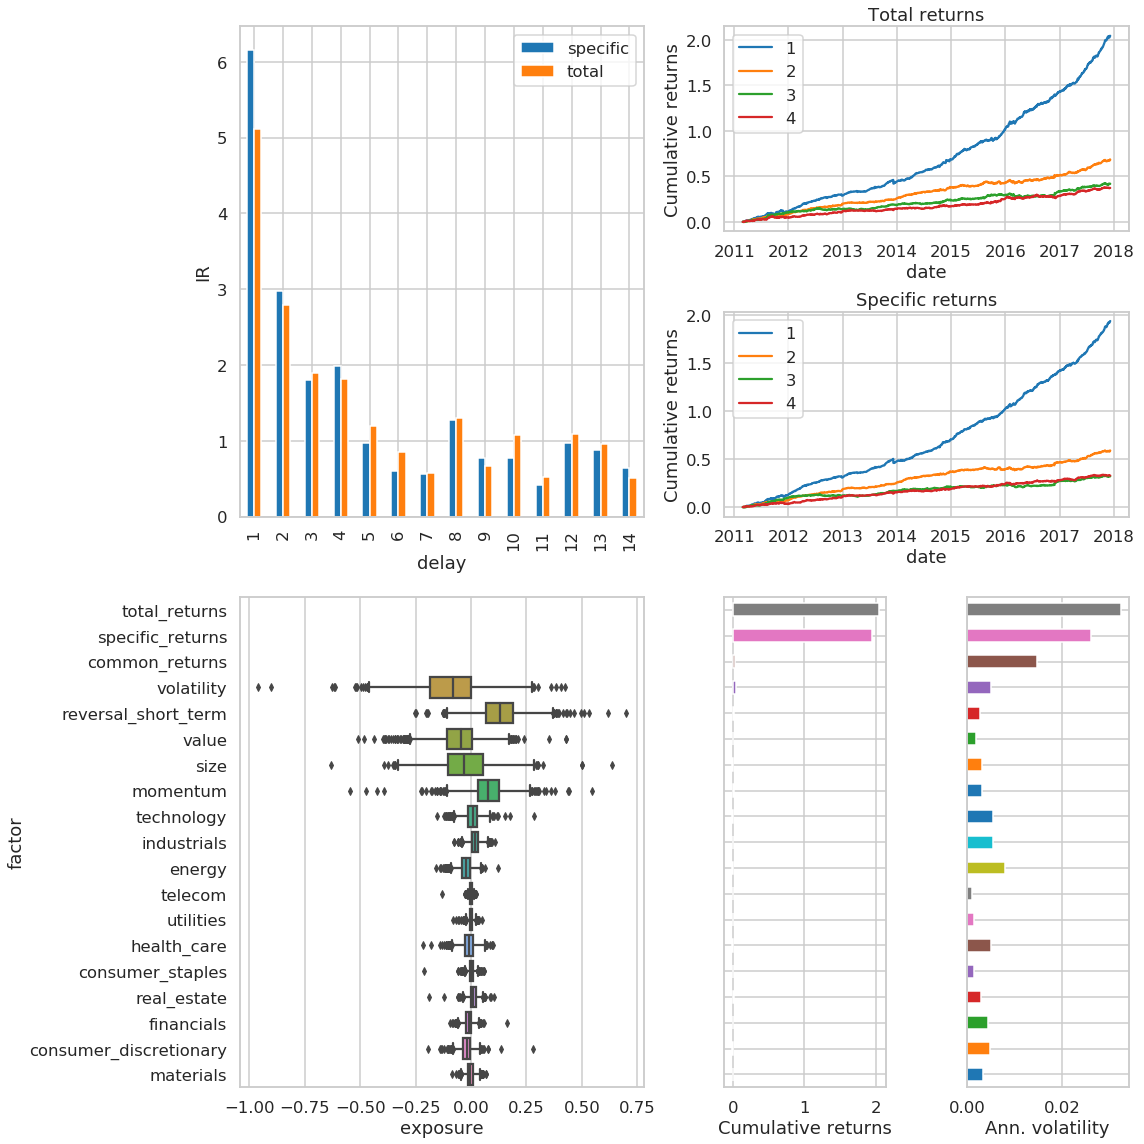

In [9]:
plot_overview_tear_sheet(weights, 
                         implied_prices,
                         risk_returns,
                         risk_loadings,
);

Of course, you can also alphalens:

Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Returns Analysis


,1D,5D,10D
Ann. alpha,0.183,0.078,0.050
beta,-0.032,-0.027,-0.021
Mean Period Wise Return Top Quantile (bps),8.957,4.085,2.805
Mean Period Wise Return Bottom Quantile (bps),-5.951,-2.549,-1.434
Mean Period Wise Spread (bps),14.908,6.634,4.242


/home/jovyan/miniconda2/envs/python3/lib/python3.5/site-packages/pandas/core/indexes/datetimes.py:840: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


<Figure size 432x288 with 0 Axes>

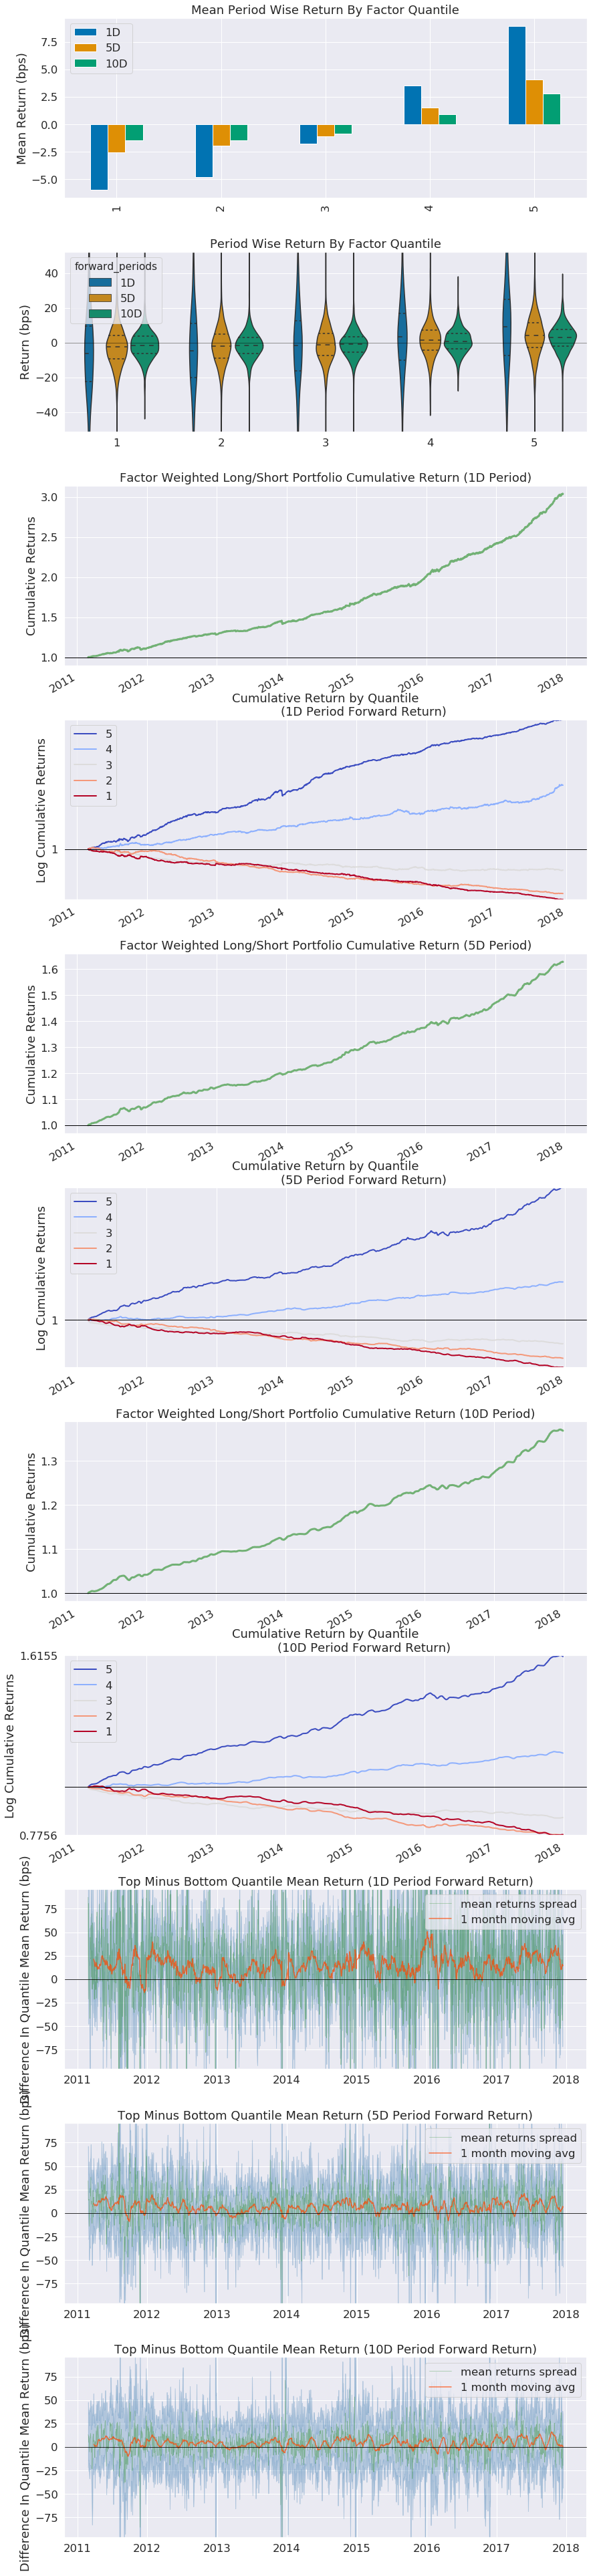

In [10]:
factor_data = al.utils.get_clean_factor_and_forward_returns(scores, 
                                                            implied_prices)
al.tears.create_returns_tear_sheet(factor_data)